In [6]:
import numpy as np
from shapely.geometry import Polygon, Point
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

In [2]:
def offset_polygon_edges(polygon_coords, selected_edges, offset_distance):
    """
    Offset multiple selected edges of a polygon, properly handling adjacent edges.
    
    Parameters:
    -----------
    polygon_coords : list of tuples
        List of (x, y) coordinates defining the polygon
    selected_edges : list of int
        Indices of the edges to offset
    offset_distance : float
        Distance to offset the edges (positive for outward, negative for inward)
    
    Returns:
    --------
    list of tuples
        New polygon coordinates with the offset edges
    """
    # Convert to numpy arrays for easier calculation
    polygon = np.array(polygon_coords)
    n = len(polygon)
    
    # Create a copy for the result
    new_polygon = polygon.copy()
    
    # Identify affected vertices
    affected_vertices = set()
    for edge_idx in selected_edges:
        affected_vertices.add(edge_idx % n)
        affected_vertices.add((edge_idx + 1) % n)
    
    # Calculate offset contributions for each vertex
    vertex_offsets = np.zeros((n, 2))
    vertex_counts = np.zeros(n)
    
    for edge_idx in selected_edges:
        v1_idx = edge_idx % n
        v2_idx = (edge_idx + 1) % n
        
        v1 = polygon[v1_idx]
        v2 = polygon[v2_idx]
        
        # Calculate edge vector and normal
        edge_vector = v2 - v1
        edge_length = np.linalg.norm(edge_vector)
        
        if edge_length > 0:
            # Normal vector (perpendicular to edge)
            normal = np.array([-edge_vector[1], edge_vector[0]]) / edge_length
            
            # Calculate offset vector
            offset_vector = normal * offset_distance
            
            # Add contribution to both vertices of this edge
            vertex_offsets[v1_idx] += offset_vector
            vertex_offsets[v2_idx] += offset_vector
            
            # Count contributions
            vertex_counts[v1_idx] += 1
            vertex_counts[v2_idx] += 1
    
    # Apply averaged offsets to affected vertices
    for v_idx in affected_vertices:
        if vertex_counts[v_idx] > 0:
            # Average the offset contributions
            new_polygon[v_idx] = polygon[v_idx] + vertex_offsets[v_idx] / vertex_counts[v_idx]
    
    return [tuple(v) for v in new_polygon]

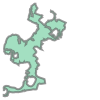

In [ ]:
polygon_path = "../datasets/mangrove_covers/refined/mangrove_polygon_refined.shp"
gdf = gpd.read_file(polygon_path)
polygon = gdf.geometry.iloc[0]

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, LineString
from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display, clear_output
%matplotlib inline

class PolygonEdgeOffset:
    """
    Interactive polygon edge offsetting for Jupyter Notebook
    """
    def __init__(self):
        self.polygon = None
        self.coords = None
        self.selected_edges = []
        self.offset_distance = 0.0
        self.result_polygon = None
        self.fig = None
        self.ax = None
    
    def load_polygon(self, shapefile_path=None, feature_index=0, coords=None):
        """
        Load a polygon from a shapefile or coordinates
        """
        if coords is not None:
            # Create from coordinates
            self.polygon = Polygon(coords)
            self.coords = np.array(coords)
            print(f"Created polygon with {len(self.coords)} vertices")
            return True
            
        elif shapefile_path:
            # Load from shapefile
            try:
                gdf = gpd.read_file(shapefile_path)
                
                if feature_index >= len(gdf):
                    print(f"Feature index {feature_index} out of range. File has {len(gdf)} features.")
                    return False
                
                geometry = gdf.iloc[feature_index].geometry
                
                # Handle different geometry types
                if geometry.geom_type == 'Polygon':
                    self.polygon = geometry
                elif geometry.geom_type == 'MultiPolygon':
                    print(f"MultiPolygon detected. Using the first polygon.")
                    self.polygon = list(geometry.geoms)[0]
                else:
                    print(f"Geometry is not a polygon, it's {geometry.geom_type}")
                    return False
                
                # Extract coordinates from the exterior ring, excluding the closing point
                self.coords = np.array(self.polygon.exterior.coords)[:-1]
                print(f"Loaded polygon with {len(self.coords)} vertices")
                return True
                
            except Exception as e:
                print(f"Error loading shapefile: {e}")
                return False
        
        print("No polygon data provided.")
        return False
    
    def plot_polygon(self):
        """
        Plot the polygon with numbered edges
        """
        if self.polygon is None:
            print("No polygon loaded")
            return
        
        plt.figure(figsize=(10, 8))
        self.fig = plt.gcf()
        self.ax = plt.gca()
        
        # Plot the polygon
        x, y = self.polygon.exterior.xy
        self.ax.fill(x, y, alpha=0.3, fc='blue', ec='black')
        
        # Plot and label each edge
        for i in range(len(self.coords)):
            start_idx = i
            end_idx = (i + 1) % len(self.coords)
            
            start = self.coords[start_idx]
            end = self.coords[end_idx]
            
            # Draw the edge
            self.ax.plot([start[0], end[0]], [start[1], end[1]], 
                    color='black', linewidth=1)
            
            # Calculate the midpoint and normal for the label
            midpoint = [(start[0] + end[0]) / 2, (start[1] + end[1]) / 2]
            edge_vector = end - start
            edge_length = np.linalg.norm(edge_vector)
            
            if edge_length > 0:
                normal = np.array([-edge_vector[1], edge_vector[0]]) / edge_length
                label_pos = midpoint + normal * 0.01 * np.max([self.polygon.bounds[2] - self.polygon.bounds[0], 
                                                            self.polygon.bounds[3] - self.polygon.bounds[1]])
                
                # Add the edge label
                self.ax.text(label_pos[0], label_pos[1], str(i), 
                            fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                            color='black')
        
        # Plot vertices
        self.ax.scatter(self.coords[:, 0], self.coords[:, 1], s=30, color='blue')
        
        # Label vertices
        for i, coord in enumerate(self.coords):
            self.ax.text(coord[0], coord[1], f'{i}', fontsize=8, ha='right', va='bottom', color='blue')
        
        # Set plot properties
        self.ax.set_aspect('equal')
        self.ax.grid(True, linestyle='--', alpha=0.7)
        self.ax.set_title("Polygon with Numbered Edges")
        plt.tight_layout()
    
    def select_edges_widget(self):
        """
        Create widget for edge selection
        """
        if self.polygon is None:
            print("No polygon loaded")
            return
        
        # Create a multi-select widget with all edge indices
        edge_options = [(f"Edge {i}", i) for i in range(len(self.coords))]
        
        # Create the widget
        edge_select = widgets.SelectMultiple(
            options=edge_options,
            description='Select Edges:',
            layout=widgets.Layout(width='300px', height='200px')
        )
        
        # Create offset slider
        max_offset = 0.05 * np.max([self.polygon.bounds[2] - self.polygon.bounds[0], 
                                 self.polygon.bounds[3] - self.polygon.bounds[1]])
        
        offset_slider = widgets.FloatSlider(
            value=0.0,
            min=-max_offset,
            max=max_offset,
            step=max_offset/100,
            description='Offset:',
            layout=widgets.Layout(width='300px')
        )
        
        # Create button for applying offset
        apply_button = widgets.Button(
            description='Apply Offset',
            button_style='primary',
            tooltip='Apply the offset to selected edges',
            layout=widgets.Layout(width='150px')
        )
        
        # Create button for saving result
        save_button = widgets.Button(
            description='Save Result',
            button_style='success',
            tooltip='Save the result to a shapefile',
            layout=widgets.Layout(width='150px')
        )
        
        # Output area for messages
        output = widgets.Output()
        
        # Function to update the plot
        def update_plot(selected_edges, offset_distance):
            with output:
                clear_output()
                
                if not selected_edges:
                    print("No edges selected")
                    return
                
                # Apply the offset
                result_polygon = self.offset_polygon_edges(self.polygon, selected_edges, offset_distance)
                self.result_polygon = result_polygon
                
                # Create a new plot
                plt.figure(figsize=(10, 8))
                
                # Plot original polygon
                x, y = self.polygon.exterior.xy
                plt.fill(x, y, alpha=0.2, fc='blue', ec='black', label='Original')
                
                # Plot result polygon
                x, y = result_polygon.exterior.xy
                plt.fill(x, y, alpha=0.2, fc='green', ec='green', label='Result')
                
                # Highlight selected edges
                for edge_idx in selected_edges:
                    start_idx = edge_idx
                    end_idx = (edge_idx + 1) % len(self.coords)
                    
                    start = self.coords[start_idx]
                    end = self.coords[end_idx]
                    
                    plt.plot([start[0], end[0]], [start[1], end[1]], 
                            color='red', linewidth=2)
                
                plt.axis('equal')
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.title(f"Polygon with Offset Edges (Offset: {offset_distance:.4f})")
                plt.legend()
                plt.tight_layout()
                plt.show()
                
                print(f"Applied offset {offset_distance:.4f} to edges: {', '.join(map(str, selected_edges))}")
        
        # Handler for the apply button
        def on_apply_button_clicked(b):
            with output:
                clear_output()
                update_plot(edge_select.value, offset_slider.value)
        
        # Handler for the save button
        def on_save_button_clicked(b):
            with output:
                clear_output()
                if self.result_polygon is None:
                    print("No result to save. Apply offset first.")
                    return
                
                try:
                    # Create a GeoDataFrame with the result
                    gdf = gpd.GeoDataFrame({'geometry': [self.result_polygon]})
                    
                    # Save to file
                    output_file = "polygon_with_offset_edges.shp"
                    gdf.to_file(output_file)
                    
                    print(f"Result saved to {output_file}")
                except Exception as e:
                    print(f"Error saving: {str(e)}")
        
        # Connect the handlers
        apply_button.on_click(on_apply_button_clicked)
        save_button.on_click(on_save_button_clicked)
        
        # Create interactive widget
        widget_box = widgets.VBox([
            edge_select, 
            offset_slider,
            widgets.HBox([apply_button, save_button]),
            output
        ])
        
        display(widget_box)
    
    def offset_polygon_edges(self, polygon, edge_indices, offset_distance):
        """
        Offset selected edges of a polygon
        
        Parameters:
        -----------
        polygon : shapely.geometry.Polygon
            The polygon to modify
        edge_indices : list of int
            Indices of edges to offset
        offset_distance : float
            Distance to offset the edges
            
        Returns:
        --------
        shapely.geometry.Polygon
            Modified polygon
        """
        # Extract coordinates from the polygon
        coords = np.array(polygon.exterior.coords)[:-1]  # Remove closing point
        n = len(coords)
        
        # Create a copy for the result
        new_coords = coords.copy()
        
        # Identify affected vertices
        affected_vertices = set()
        for edge_idx in edge_indices:
            affected_vertices.add(edge_idx % n)
            affected_vertices.add((edge_idx + 1) % n)
        
        # Calculate offset contributions for each vertex
        vertex_offsets = np.zeros((n, 2))
        vertex_counts = np.zeros(n)
        
        for edge_idx in edge_indices:
            v1_idx = edge_idx % n
            v2_idx = (edge_idx + 1) % n
            
            v1 = coords[v1_idx]
            v2 = coords[v2_idx]
            
            # Calculate edge vector and normal
            edge_vector = v2 - v1
            edge_length = np.linalg.norm(edge_vector)
            
            if edge_length > 0:
                # Normal vector (perpendicular to edge)
                normal = np.array([-edge_vector[1], edge_vector[0]]) / edge_length
                
                # Calculate offset vector
                offset_vector = normal * offset_distance
                
                # Add contribution to both vertices of this edge
                vertex_offsets[v1_idx] += offset_vector
                vertex_offsets[v2_idx] += offset_vector
                
                # Count contributions
                vertex_counts[v1_idx] += 1
                vertex_counts[v2_idx] += 1
        
        # Apply averaged offsets to affected vertices
        for v_idx in affected_vertices:
            if vertex_counts[v_idx] > 0:
                # Average the offset contributions
                new_coords[v_idx] = coords[v_idx] + vertex_offsets[v_idx] / vertex_counts[v_idx]
        
        # Create new polygon (ensure it's closed)
        new_polygon_coords = list(map(tuple, new_coords))
        
        # Handle any interior rings (holes)
        interiors = []
        for interior in polygon.interiors:
            interiors.append(list(interior.coords))
        
        if interiors:
            return Polygon(new_polygon_coords, interiors)
        else:
            return Polygon(new_polygon_coords)

Loaded 3 features from ../datasets/mangrove_covers/refined/mangrove_polygon_refined.shp


interactive(children=(IntSlider(value=0, description='Feature:', layout=Layout(width='300px'), max=2), Output(…

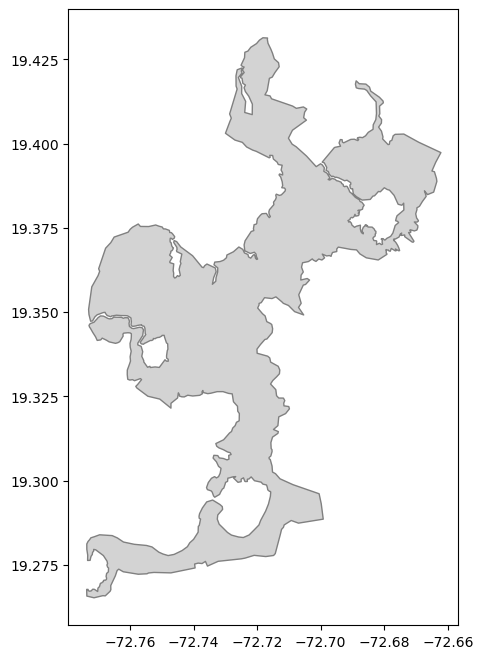

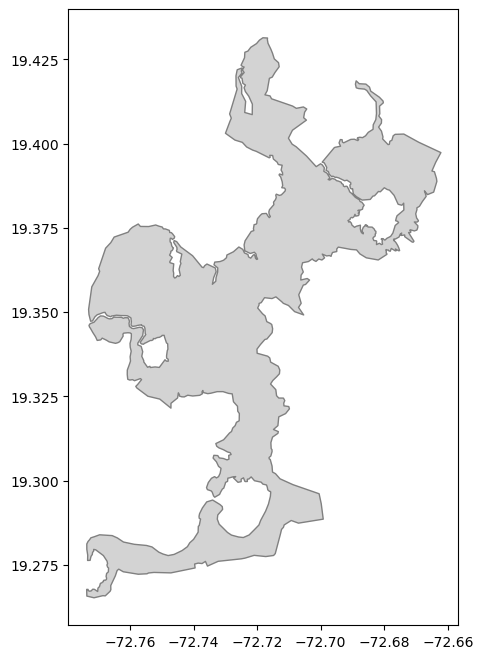

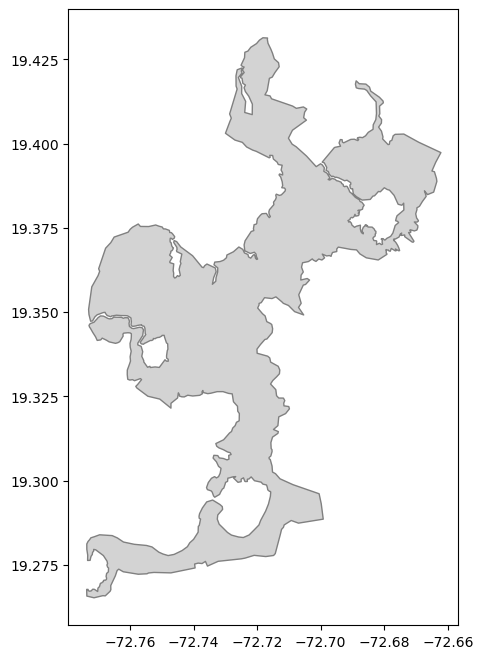

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display
%matplotlib inline

# Load shapefile
def load_shapefile(shapefile_path):
    try:
        gdf = gpd.read_file(shapefile_path)
        print(f"Loaded {len(gdf)} features from {shapefile_path}")
        return gdf
    except Exception as e:
        print(f"Error loading shapefile: {e}")
        return None

# Simple function to display a shapefile with a specific feature highlighted
def display_shapefile(gdf, feature_index=0):
    if gdf is None or len(gdf) == 0:
        print("No data to display")
        return
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot all features in light gray
    gdf.plot(ax=ax, color='lightgray', edgecolor='gray')
    
    # Highlight the selected feature
    if feature_index < len(gdf):
        gdf.iloc[[feature_index]].plot(ax=ax, color='blue', edgecolor='black')
        
        # If it's a polygon, number the edges
        geom = gdf.iloc[feature_index].geometry
        if geom.geom_type in ['Polygon', 'MultiPolygon']:
            if geom.geom_type == 'Polygon':
                polygons = [geom]
            else:
                polygons = list(geom.geoms)
            
            for poly in polygons:
                coords = list(poly.exterior.coords)
                for i in range(len(coords)-1):
                    # Get midpoint of edge
                    mid_x = (coords[i][0] + coords[i+1][0])/2
                    mid_y = (coords[i][1] + coords[i+1][1])/2
                    ax.text(mid_x, mid_y, str(i), fontsize=9, 
                           bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(f"Feature {feature_index} of {len(gdf)}")
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load your shapefile
gdf = load_shapefile("../datasets/mangrove_covers/refined/mangrove_polygon_refined.shp")  # Replace with your path

if gdf is not None:
    # Create a feature selector widget
    feature_selector = widgets.IntSlider(
        value=0,
        min=0,
        max=max(0, len(gdf)-1),
        step=1,
        description='Feature:',
        layout=widgets.Layout(width='300px')
    )
    
    # Create interactive widget
    interact(display_shapefile, gdf=fixed(gdf), feature_index=feature_selector)

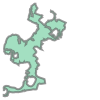

In [31]:
polygon

In [30]:
edge_indices = np.arange(250, 751)
offset_distance = 2
offset_polygon_edges(polygon, edge_indices, offset_distance)

TypeError: len() of unsized object

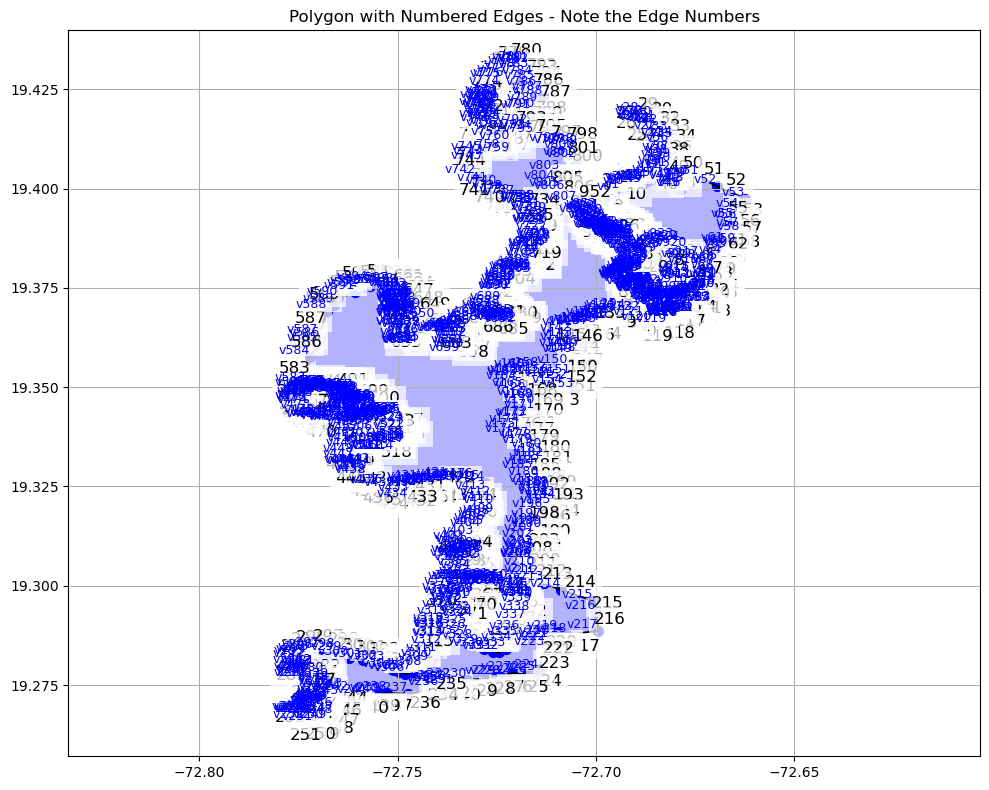

The polygon has 953 edges (numbered 0 to 952).
Note down the edge numbers you want to offset and enter them in the widget below.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display, clear_output
%matplotlib inline

# 1. Load your shapefile
shapefile_path = "../datasets/mangrove_covers/refined/mangrove_polygon_refined.shp"  # Replace with your actual path
gdf = gpd.read_file(shapefile_path)

# 2. Select the polygon you want to work with (e.g., the first one)
feature_index = 0  # Change this if you want a different feature
polygon = gdf.iloc[feature_index].geometry

# Handle MultiPolygon if needed
if polygon.geom_type == 'MultiPolygon':
    polygon = list(polygon.geoms)[0]
    print(f"MultiPolygon detected. Using the first polygon.")
elif polygon.geom_type != 'Polygon':
    raise ValueError(f"Geometry is not a polygon, it's {polygon.geom_type}")

# 3. Define the edge offsetting function
def offset_polygon_edges(polygon, edge_indices, offset_distance):
    """Offset selected edges of a polygon"""
    # Extract coordinates
    coords = np.array(polygon.exterior.coords)[:-1]  # Remove closing point
    n = len(coords)
    
    # Create a copy for the result
    new_coords = coords.copy()
    
    # Identify affected vertices
    affected_vertices = set()
    for edge_idx in edge_indices:
        affected_vertices.add(edge_idx % n)
        affected_vertices.add((edge_idx + 1) % n)
    
    # Calculate offset contributions for each vertex
    vertex_offsets = np.zeros((n, 2))
    vertex_counts = np.zeros(n)
    
    for edge_idx in edge_indices:
        v1_idx = edge_idx % n
        v2_idx = (edge_idx + 1) % n
        
        v1 = coords[v1_idx]
        v2 = coords[v2_idx]
        
        # Calculate edge vector and normal
        edge_vector = v2 - v1
        edge_length = np.linalg.norm(edge_vector)
        
        if edge_length > 0:
            # Normal vector (perpendicular to edge)
            normal = np.array([-edge_vector[1], edge_vector[0]]) / edge_length
            
            # Calculate offset vector
            offset_vector = normal * offset_distance
            
            # Add contribution to both vertices of this edge
            vertex_offsets[v1_idx] += offset_vector
            vertex_offsets[v2_idx] += offset_vector
            
            # Count contributions
            vertex_counts[v1_idx] += 1
            vertex_counts[v2_idx] += 1
    
    # Apply averaged offsets to affected vertices
    for v_idx in affected_vertices:
        if vertex_counts[v_idx] > 0:
            # Average the offset contributions
            new_coords[v_idx] = coords[v_idx] + vertex_offsets[v_idx] / vertex_counts[v_idx]
    
    # Create new polygon (ensure it's closed)
    new_polygon_coords = list(map(tuple, new_coords))
    
    # Handle any interior rings (holes)
    interiors = []
    for interior in polygon.interiors:
        interiors.append(list(interior.coords))
    
    if interiors:
        return Polygon(new_polygon_coords, interiors)
    else:
        return Polygon(new_polygon_coords)

# 4. First, display the polygon with numbered edges
def plot_numbered_polygon(polygon):
    """Display polygon with edge numbers"""
    plt.figure(figsize=(10, 8))
    
    # Extract coordinates
    coords = np.array(polygon.exterior.coords)[:-1]
    
    # Plot the polygon
    x, y = polygon.exterior.xy
    plt.fill(x, y, alpha=0.3, fc='blue', ec='black')
    
    # Plot and label each edge
    for i in range(len(coords)):
        start = coords[i]
        end = coords[(i+1) % len(coords)]
        
        # Draw the edge
        plt.plot([start[0], end[0]], [start[1], end[1]], 'k-')
        
        # Calculate midpoint for label
        midpoint = [(start[0] + end[0])/2, (start[1] + end[1])/2]
        
        # Calculate normal for label offset
        edge_vector = end - start
        edge_length = np.linalg.norm(edge_vector)
        if edge_length > 0:
            normal = np.array([-edge_vector[1], edge_vector[0]]) / edge_length
            label_pos = midpoint + normal * 0.02 * np.max([
                polygon.bounds[2] - polygon.bounds[0], 
                polygon.bounds[3] - polygon.bounds[1]
            ])
            
            # Add label
            plt.text(label_pos[0], label_pos[1], str(i), 
                    fontsize=12, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Plot vertices
    plt.scatter(coords[:, 0], coords[:, 1], c='blue', s=50)
    
    # Label vertices
    for i, coord in enumerate(coords):
        plt.text(coord[0], coord[1], f'v{i}', 
                fontsize=9, ha='right', va='bottom', color='blue')
    
    plt.grid(True)
    plt.axis('equal')
    plt.title('Polygon with Numbered Edges - Note the Edge Numbers')
    plt.tight_layout()
    plt.show()
    
    # Print guidance
    print(f"The polygon has {len(coords)} edges (numbered 0 to {len(coords)-1}).")
    print("Note down the edge numbers you want to offset and enter them in the widget below.")

# 5. Create interactive widget for edge offsetting
def update_polygon(selected_edges, offset_distance, save_result=False):
    """Update the polygon with offset edges"""
    # Clear previous output
    clear_output(wait=True)
    
    # Convert input to list of indices
    if isinstance(selected_edges, str):
        try:
            # Handle comma-separated values
            selected_indices = [int(idx.strip()) for idx in selected_edges.split(',') if idx.strip()]
        except ValueError:
            print("Invalid edge indices. Please enter comma-separated numbers.")
            return
    else:
        selected_indices = selected_edges
    
    if not selected_indices:
        print("No edges selected. Please enter edge indices.")
        return
    
    # Apply offset
    result_polygon = offset_polygon_edges(polygon, selected_indices, offset_distance)
    
    # Plot the result
    plt.figure(figsize=(10, 8))
    
    # Original polygon
    x, y = polygon.exterior.xy
    plt.fill(x, y, alpha=0.2, fc='blue', ec='black', label='Original')
    
    # Result polygon
    x, y = result_polygon.exterior.xy
    plt.fill(x, y, alpha=0.2, fc='green', ec='green', label='Result')
    
    # Highlight selected edges
    coords = np.array(polygon.exterior.coords)[:-1]
    for edge_idx in selected_indices:
        if edge_idx < len(coords):
            start = coords[edge_idx]
            end = coords[(edge_idx+1) % len(coords)]
            plt.plot([start[0], end[0]], [start[1], end[1]], 
                    color='red', linewidth=2)
    
    plt.axis('equal')
    plt.grid(True)
    plt.title(f"Polygon with Offset Edges (Offset: {offset_distance:.4f})")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Save result if requested
    if save_result:
        output_file = "polygon_with_offset_edges.shp"
        result_gdf = gpd.GeoDataFrame({'geometry': [result_polygon]}, crs=gdf.crs)
        result_gdf.to_file(output_file)
        print(f"Result saved to {output_file}")
    
    print(f"Applied offset {offset_distance:.4f} to edges: {', '.join(map(str, selected_indices))}")
    return result_polygon

# 6. Display the polygon with numbered edges
plot_numbered_polygon(polygon)

# 7. Create widgets for interactive offsetting
edge_input = widgets.Text(
    value='',
    placeholder='e.g., 0,1,2',
    description='Edge Indices:',
    tooltip='Enter comma-separated edge indices',
    layout=widgets.Layout(width='300px')
)

# Calculate a reasonable max offset based on polygon bounds
max_offset = 0.1 * min(
    polygon.bounds[2] - polygon.bounds[0],
    polygon.bounds[3] - polygon.bounds[1]
)

offset_slider = widgets.FloatSlider(
    value=0.0000,
    min=-0.0100,
    max=0.0100,
    step=max_offset/10,
    description='Offset:',
    layout=widgets.Layout(width='300px')
)

save_checkbox = widgets.Checkbox(
    value=False,
    description='Save result',
    layout=widgets.Layout(width='150px')
)

# Create run button
run_button = widgets.Button(
    description='Apply Offset',
    button_style='primary',
    tooltip='Apply the offset to selected edges',
    layout=widgets.Layout(width='150px')
)

output = widgets.Output()

# Run button click handler
def on_run_button_clicked(b):
    with output:
        clear_output()
        result = update_polygon(edge_input.value, offset_slider.value, save_checkbox.value)

run_button.on_click(on_run_button_clicked)

# Display widgets
display(widgets.VBox([
    widgets.HTML(value="<b>Step 1: Enter the edge indices you want to offset (comma-separated)</b>"),
    edge_input,
    widgets.HTML(value="<b>Step 2: Adjust the offset amount</b>"),
    offset_slider,
    widgets.HTML(value="<b>Step 3: Check if you want to save the result</b>"),
    save_checkbox,
    widgets.HTML(value="<b>Step 4: Click Apply to see the result</b>"),
    run_button,
    output
]))

In [44]:
integer_list = list(range(252, 810))

# Convert to comma-separated string
comma_separated = ", ".join(map(str, integer_list))

print(comma_separated)

252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 

In [ ]:
252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

In [23]:
selected_edges = np.arange(250, 751) # Bottom edges

gdf = gpd.read_file("../datasets/mangrove_covers/refined/mangrove_polygon_refined.shp")
polygon = gdf.geometry.iloc[0]
result = offset_polygon_edges(polygon, selected_edges, 0.2)

# Visualization
plt.figure(figsize=(10, 8))
plt.plot(*zip(*polygon, polygon[0]), 'k--', label='Original')
plt.plot(*zip(*result, result[0]), 'b-', label='With Offset Edges')

# Highlight the selected edges
for edge_idx in selected_edges:
    v1_idx = edge_idx % len(polygon)
    v2_idx = (edge_idx + 1) % len(polygon)
    plt.plot([polygon[v1_idx][0], polygon[v2_idx][0]], 
             [polygon[v1_idx][1], polygon[v2_idx][1]], 'r-', linewidth=2)

plt.grid(True)
plt.axis('equal')
plt.legend()
plt.title('Complex Polygon with Multiple Edge Offsets')
plt.show()

TypeError: len() of unsized object